In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import time

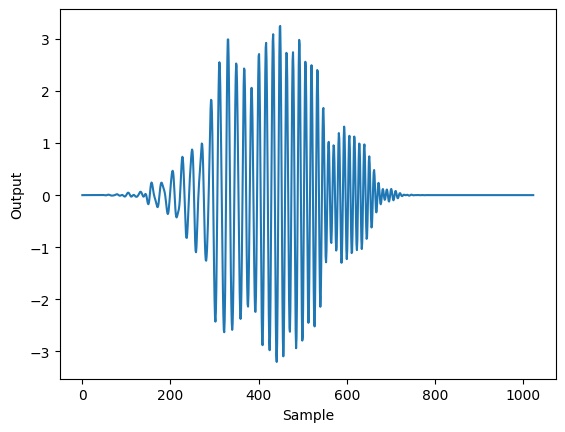

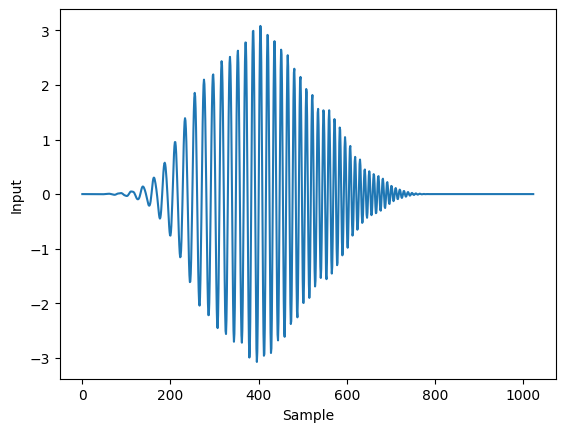

In [12]:
# Load dataset
data = np.genfromtxt("data/flutter.dat")
u = data[:,0]
y = data[:,1]
t_ = np.linspace(0, len(y)-1, len(y))

plt.figure()
plt.plot(t_, y)
plt.xlabel("Sample")
plt.ylabel("Output")

plt.figure()
plt.plot(t_, u)
plt.xlabel("Sample")
plt.ylabel("Input")
plt.show()

In [45]:
# Construct X and Y matrices for regression
num_delays = 3
assert num_delays >= 1, "Delays must be a positive integer"
train_test_split = 0.4
assert train_test_split > 0 and train_test_split < 1, "Train/test split must be between 0 and 1"

Y = np.expand_dims(y[num_delays:], axis=1)
X = np.zeros(shape=(len(y)-num_delays, 2*num_delays))
for i in range(len(y)-num_delays):
    X[i,:num_delays] = y[i:i+num_delays]
    X[i,num_delays:] = u[i:i+num_delays]

# Split into train and test sets
train_test_index = int(Y.shape[0]*train_test_split)
Y_train = Y[:train_test_index,:]
Y_test  = Y[train_test_index:,:]
X_train = X[:train_test_index,:]
X_test  = X[train_test_index:,:]

In [ ]:
# Construct LS model
ls_lift_order = 1
